In [3]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join
import shlex

import joblib
from concurrent.futures import ProcessPoolExecutor
import re

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma

import psrchive

import pipe

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
#test_obs = "data/obs/56297.32_GBT_1400"
#test_obs = "data/obs/56645.09_AO_1400"
#test_obs = "data/obs/57431.99_AO_2000"
#test_obs = "data/obs/57432.00_AO_350"
#test_obs = "data/obs/57422.97_AO_430"
#test_obs = "data/obs/56039.69_WSRT_350"
test_obs = "data/obs/56040.34_WSRT_1400"
#test_obs = "data/obs/56163.27_WSRT_1400"

work_dir = "/tmp/cal_zap_test"
M = pickle.load(open(join(test_obs,"meta.pickle"),"rb"))
if os.path.exists(work_dir):
    shutil.rmtree(work_dir)
os.makedirs(work_dir)
td = work_dir

if "align_files" not in M:
    M["align_files"] = ["align.ar"]

tfs = [join(td,os.path.basename(f)) for f in M["align_files"]]
for (f,tf) in zip(M["align_files"], tfs):
    shutil.copy(join(test_obs,f),tf)
r = re.compile(r"\.[^.]*$")
cfs = [r.sub(".calib", tf) for tf in tfs]
cfPs = [r.sub(".calibP", tf) for tf in tfs]
zfs = [r.sub(".zap", tf) for tf in tfs]
wfs = [r.sub(".wt", tf) for tf in tfs]


M.keys()
if "receiver" not in M:
    if M["tel"] == "WSRT":
        M["receiver"] = "PuMa2_"+str(M["band"])
    else:
        F = psrchive.Archive_load(tfs[0])
        M["receiver"] = F.get_receiver_name()

print F.get_receiver_name()
print F.get_backend_name()
print F.get_telescope()

M["align_files"]

Rcvr1_2
GUPPI
GBT


['align.ar']

In [253]:

if M["tel"]=="WSRT":
    for tf, cfP in zip(tfs, cfPs):
        shutil.copy(tf, cfP)
else:
    P = subprocess.Popen(["pac",
                    "-Ta",
                    "-d","data/cal/cal.db"]
                    + tfs, 
                    stdout=subprocess.PIPE, 
                    stderr=subprocess.PIPE)

    out, err = P.communicate()
    print out
    print err
    if P.returncode:
        raise ValueError("Return code %d" % P.returncode)

In [254]:

# Standard zap commands (paz arguments) to apply per receiver
# 'default' is applied to any reciever not listed
zap = {
        'Rcvr1_2':["-F","1100 1150",
                   "-F","1250 1262", 
                   "-F","1288 1300",
                   "-F","1373 1381",
                   "-F","1442 1447",
                   "-F","1525 1558",
                   "-F","1575 1577",
                   "-F","1615 1630",
                   "-F","1370 1385"],
        'Rcvr_800':["-F","794.6 798.6",
                    "-F","814.1 820.7"],
        '327':[],
        '430':["-F","380 420", 
               "-F","446 480"],
        'lbw':["-F","980 1150",
                  "-F","1618 1630"],
        'sbw':["-F","1600 1770",
                  "-F","1880 2050",
                  "-F","2100 2160",
                  "-F","2400 2600"],
        'PuMa2_350':[],
        'PuMa2_1400':[],
    }


In [255]:
zo = zap[M['receiver']]
P = subprocess.Popen(["paz", "-r", "-R", "20", "-e", "zap"]
                + zo
                + cfPs, 
                stdout=subprocess.PIPE, 
                stderr=subprocess.PIPE)

out, err = P.communicate()
print out
print err
if P.returncode:
    raise ValueError("Return code %d" % P.returncode)

Using median smoothed difference zapper
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""
Equivalent paz cmd: paz -z ""


(769, 512)


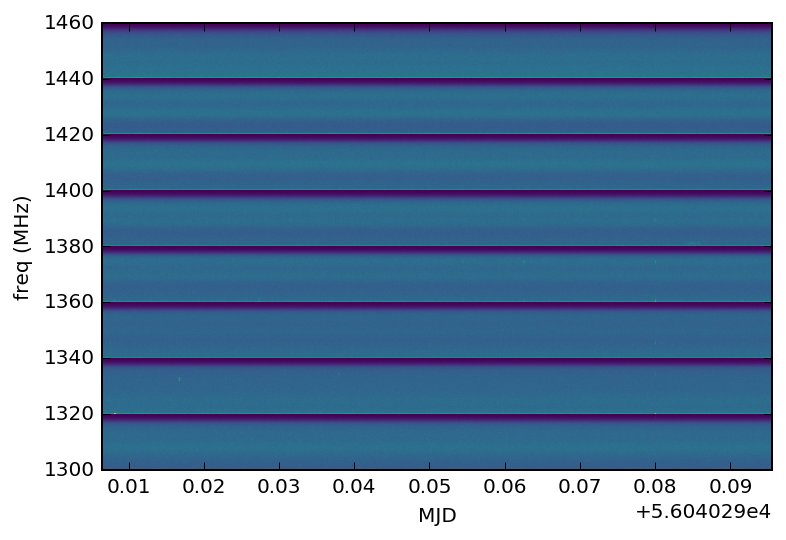

In [256]:
for f in zfs:
    F = psrchive.Archive_load(f)
    F.pscrunch()
    F.remove_baseline()
    d = F.get_data()[:,0,:,:]
    w = F.get_weights()
    s = ma.array(np.std(d,axis=-1))
    s[w==0] = ma.masked
    bw = F.get_bandwidth()
    if bw<0:
        s = s[:,::-1]
        bw = -bw
    plt.imshow(s[:,::-1].T, extent=(F.start_time().in_days(),
                            F.end_time().in_days(),
                            F.get_centre_frequency()-bw/2,
                            F.get_centre_frequency()+bw/2))
    print s.shape
plt.gca().set_aspect('auto')
plt.xlabel("MJD")
plt.ylabel("freq (MHz)")

In [257]:
fin = zfs[0]
pipe.check_call(["pam", "-D", "-e", "dedisp", fin])
fout = fin.replace(".zap",".dedisp")
pipe.check_call(["psrwt", "-n", "-s", "0", fout])
fwt = fout + ".wt"

In [258]:
profile_nowt = join(td,"profile.nowt")
pipe.check_call(["psradd", "-T", "-o", profile_nowt] + zfs)
pipe.check_call(["pam", "-m", "-DFTp", profile_nowt])

In [259]:
#off_pulse = [(0.23,0.4), (0.73,0.90)]
off_pulse = [(0.33,0.5), (0.83,1.0)]


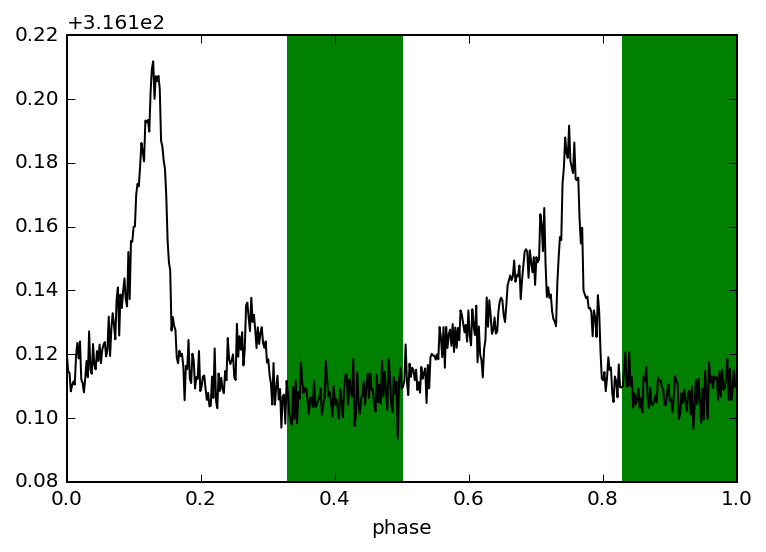

In [260]:
P = psrchive.Archive_load(profile_nowt)
d = P.get_data().squeeze()
xs = np.linspace(0,1,len(d),endpoint=False)
plt.plot(xs,d, color='black')
for b,e in off_pulse:
    plt.axvspan(b,e,color='green',zorder=-10)
plt.xlabel("phase")    

In [261]:
c = xs <= 0
for (b,e) in off_pulse:
    c |= (xs>=b) & (xs<=e)
print np.sum(c), len(c)

176 512


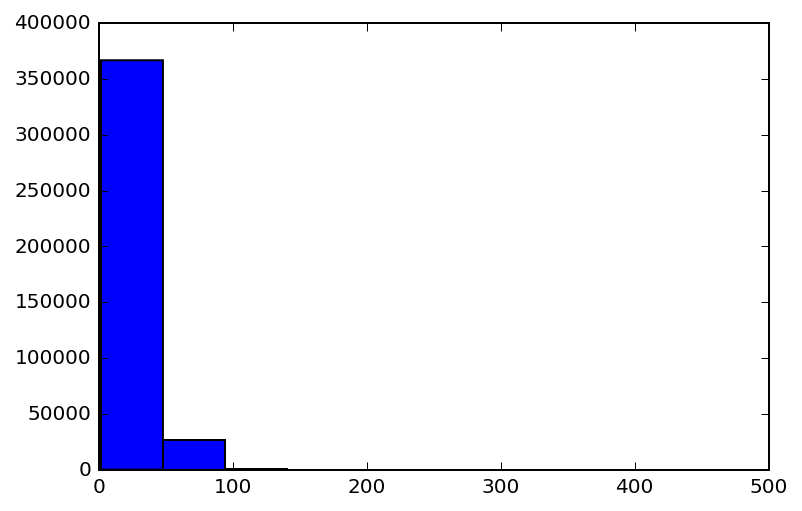

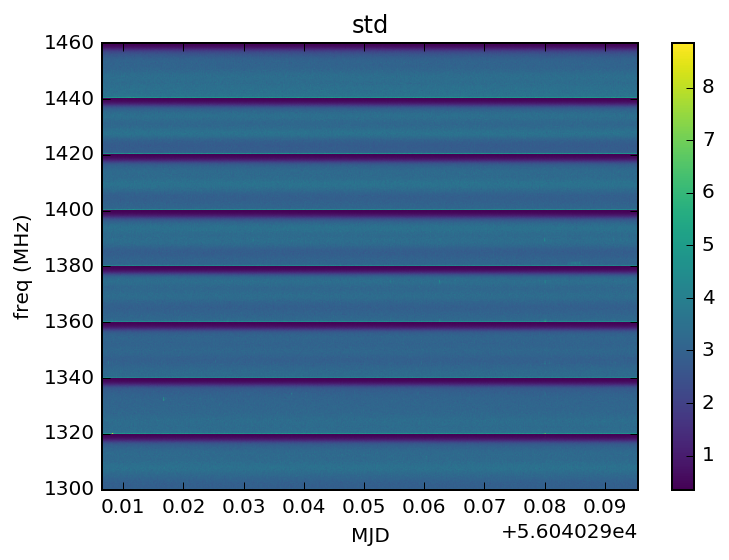

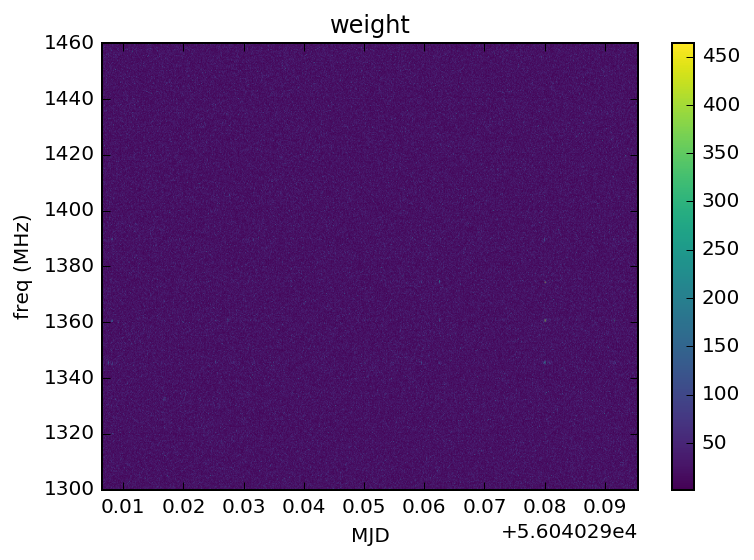

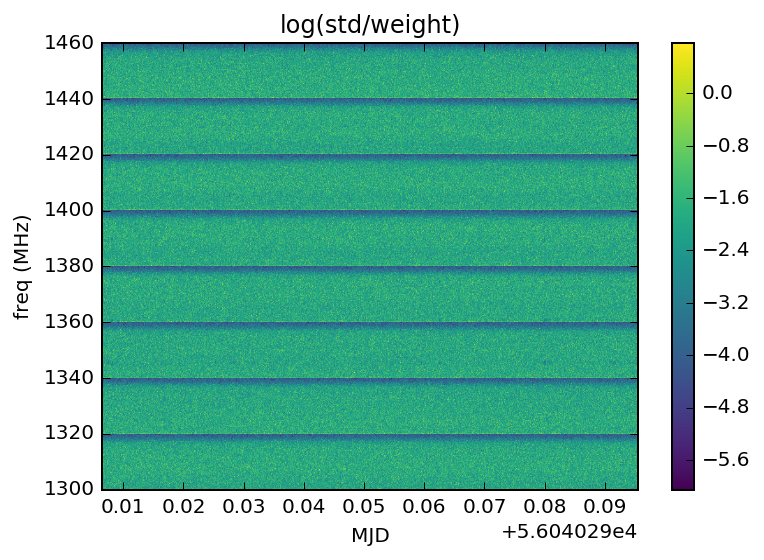

In [264]:
fwt = fout + ".wt"

F = psrchive.Archive_load(fwt)
F.pscrunch()
G = psrchive.Archive_load(fout)
G.pscrunch()

d = G.get_data()[:,0,:,:]
w = F.get_weights()
#s = ma.array(d[:,:,c].std(axis=-1))
s = ma.array(d.std(axis=-1))
s[w==0] = ma.masked

plt.figure()
plt.hist(w.reshape((-1,)))

plt.figure()
bw = F.get_bandwidth()
if bw<0:
    w = w[:,::-1]
    s = s[:,::-1]
    bw = -bw
plt.imshow(s[:,::-1].T, extent=(F.start_time().in_days(),
                        F.end_time().in_days(),
                        F.get_centre_frequency()-bw/2,
                        F.get_centre_frequency()+bw/2))
plt.colorbar()
plt.gca().set_aspect('auto')
plt.title("std")
plt.xlabel("MJD")
plt.ylabel("freq (MHz)")
plt.savefig("std-plot.pdf")

plt.figure()
plt.imshow(w[:,::-1].T, extent=(F.start_time().in_days(),
                        F.end_time().in_days(),
                        F.get_centre_frequency()-bw/2,
                        F.get_centre_frequency()+bw/2))
plt.colorbar()
plt.gca().set_aspect('auto')
plt.title("weight")
plt.xlabel("MJD")
plt.ylabel("freq (MHz)")

plt.figure()
plt.imshow(np.log(s/w)[:,::-1].T, extent=(F.start_time().in_days(),
                        F.end_time().in_days(),
                        F.get_centre_frequency()-bw/2,
                        F.get_centre_frequency()+bw/2))
plt.colorbar()
plt.gca().set_aspect('auto')
plt.title("log(std/weight)")
plt.xlabel("MJD")
plt.ylabel("freq (MHz)")

Suppose we have a collection of measured profiles $P_i$ with differing amounts of noise $n_{i,j} \sim N(0,\sigma_j)$, and we want to form an average profile 
$$ P_i + r_i = \frac{\sum_j w_j (P_{i,j}+n_{i,j})}{\sum_j w_j}. $$
Then 
$$ r_i \sim N\left(0,\frac{\sqrt{\sum w_j^2\sigma_j^2}}{\sum_j w_j} \right). $$
The optimal weighting is (proportional to) $w_j = 1/\sigma_j$, which gives $r_i\sim N(0,\sqrt{n}/\sum_j 1/\sigma_j)$. Uniform weighting gives $r_i \sim N(0,(1/n)\sqrt{\sum_j \sigma_j^2})$.

In [263]:
ua = np.sqrt((s**2).sum())/(s**0).sum()
oa = np.sqrt((s**0).sum())/(1/s).sum()
print "uniform averaging:", ua
print "optimal averaging:", oa
print "factor:", ua/oa


uniform averaging: 0.00476601
optimal averaging: 0.0033076
factor: 1.44093


In [204]:
M.keys()

['mjd',
 'zaps',
 'par',
 'nchan',
 'tel',
 'name',
 'centre_frequency',
 'band',
 'align_files',
 'clean_files',
 'obs_dir',
 'P',
 'length',
 'nsubint',
 'max_smearing',
 'receiver',
 'input_files']

In [205]:
I = F.get_first_Integration()

In [206]:
I.get_centre_frequency()

1380.0

In [207]:
G = psrchive.Archive_load(tfs[0])

In [208]:
print G.get_nchan(), F.get_nchan()

512 512


In [209]:
F.get_weights().shape

(769, 512)

In [210]:
F.get_bandwidth()

160.0

In [ ]:
F.get_telescope()

In [ ]:
F.get_centre_frequency()

In [ ]:
F.get_bandwidth()

In [ ]:
F.get_nchan()

## Adding manual zapping

In [13]:
obs_dir = "/export/astron/archibald/projects/triplesystem/processing/data/obs/56496.15_WSRT_1400"

g = glob(join(obs_dir,"manual.pazi"))
zapchans = []
zapsubs = []
if g:
    for l in open(g[0]).readlines():
        s = shlex.split(l)
        for (i,k) in enumerate(s):
            if k=="-z":
                zapchans += [int(c) for c in s[i+1].split()]
            elif k=="-w":
                zapsubs += [int(c) for c in s[i+1].split()]
            elif k=="-Z":
                b,e = [int(c) for c in s[i+1].split()]
                zapchans += range(b,e+1)
            elif k=="-W":
                b,e = [int(c) for c in s[i+1].split()]
                zapsubs += range(b,e+1)
            elif k in ["-f","-F","-x","-X","-E","-s","-S"]:
                raise ValueError("Edit '%s' not supported" % k)
print zapchans
print zapsubs

[64, 70, 71, 72, 73, 143, 144, 145, 146, 147, 148, 219, 220, 221, 222, 223, 224]
[]


In [11]:
!paz -h


paz - zaps RFI in archives

usage: paz [options] filename[s] 

where options are:

  -h,-help         print this help page
  -i,-version      version information
  -q               quiet mode
  -v               verbose mode
  -V               very verbose mode
  -M metafile      metafile contains list of archive filenames
  -config file     configuration file

Preprocessing options:
  -j commands      execute pulsar shell preprocessing commands
  -J script        execute pulsar shell preprocessing script

Output options:
  -m               modify (overwrite) the original file
  -e ext           write files with a new extension
  -O path          write files to a new directory

Manual zapping options:
  -I               Zero weight the intersection of -[wW] and -[zZk]
  -k filename      Zero weight chans listed in this kill file
  -B "a b"         Zap pulse phase bins between a and b inclusive
  -z "a b c ..."   Zero weight these particular channels
  -Z "a b"         Zero weight chans